## Purpose: 
Model the ad auction and develop an effective algorithm for bidding in a landscape of strategic competitors.
Building a Second-Price Auction (Modeling and Strategy)
You have been hired by a major retailer to develop algorithms for an online ad auction. Your client knows a little about the multi-armed bandit literature and recognizes that it can spend money to explore and learn how likely users are to click on ads or to exploit, spending on the most promising users to maximize immediate payoffs. At the same time, other companies are participating in auctions that may outbid your client, potentially interfering with these goals.

Your task is to model the ad auction and develop an effective algorithm for bidding in a landscape of strategic competitors. Your client plans to test your bidding algorithm against other bidding algorithms contributed by other data scientists in order to select the most promising algorithm.

### The Auction Rules 
The Auction is a game involving a set of Bidders on one side and a set of Users on the other. Each round represents an event where a user navigates to a website with a space for an ad. When this happens, the Bidders will place bids, and the winner gets to show their ad to the User. The user may click on the ad or not click, and the winning Bidder gets to observe the user's behavior. This is a second-price sealed-bid Auction. There are num_users Users, numbered from 0 to num_users - 1. The number corresponding to a user will be called by its user_id _. Each user has a secret probability of clicking whenever an ad is shown; the probability is the same, no matter which Bidder gets to show the ad, and the probability never changes. The events of clicking on each ad are mutually independent. When a user is created, the secret probability is drawn from a uniform distribution from 0 to 1.
There is a set of Bidders. Each Bidder begins with a balance of 0 dollars. The objective is to finish the game with as high a balance as possible. At some points during the game, the Bidder's balance may become negative. If your Bidder's balance goes below -1000 dollars, then your bidder will be disqualified from the Auction and further bidding. 

In [1]:
import random
import matplotlib.pyplot as plt

class User:
    '''Class to represent a user with a secret probability of clicking an ad.'''
    
    def __init__(self):
        '''Generating a probability between 0 and 1 from a uniform distribution'''
        self.__probability = random.uniform(0, 1)  # Secret probability of clicking an ad

    def __repr__(self):
        '''User object with secret probability'''
        return f'User(probability={self.__probability:.2f})'

    def __str__(self):
        '''Return User object with a secret likelihood of clicking on an ad'''
        return f'User object with a secret likelihood of clicking on an ad: {self.__probability:.2%}'
    
    def show_ad(self):
        '''Returns True to represent the user clicking on an ad or False otherwise'''
        return random.random() <= self.__probability

#Class to manages bidding strategy 
class Bidder:
    '''Class to represent a bidder in an online second-price ad auction'''
    
    def __init__(self, num_users, num_rounds):
        """
        Initializes a new Bidder instance.

        :param num_users: Number of user objects in the game
        :param num_rounds: Total number of rounds to be played
        """
        self.num_users = num_users
        self.num_rounds = num_rounds
        self.balance = 0.0  # Initial balance
        self.user_click_prob_estimates = [0.5 for _ in range(num_users)] # Initialize with a neutral estimate
        self.bid_history = [] # Keep track of all bids placed
        self.is_qualified = True #tracks if the bidder is qualified

    def __repr__(self):
        '''Return a Bidder object with balance.'''
        return f'Bidder(balance={self.balance})'

    def __str__(self):
        '''Return a Bidder object with balance.'''
        return f'Bidder with balance: {self.balance}'
    
    def bid(self, user_id):
        """
        Places a bid for a user based on the user_id.

        :param user_id: The ID of the user to place a bid for
        :return: A non-negative amount of money, rounded to three decimal places
        """
        # Start with a conservative bid approach
        minimum_bid = 0.1
        if self.balance > 1:  # Once some balance is accumulated, consider a more dynamic strategy
            rounds_left = max(self.num_rounds - len(self.bid_history), 1)
            safe_bid_amount = min(0.2, self.balance / (rounds_left * 2))  # Limit the bid amount based on rounds left
            estimated_click_prob = self.user_click_prob_estimates[user_id]
            dynamic_bid = safe_bid_amount * estimated_click_prob
            bid_amount = max(dynamic_bid, minimum_bid)
        else:
            bid_amount = minimum_bid  # Stick to the minimum bid initially
        bid_amount = round(bid_amount, 3)
        return bid_amount

    def notify(self, auction_winner, price, clicked):
        """
        Receives notification about the auction outcome and updates the bidder's strategy.

        :param auction_winner: Boolean indicating whether this bidder won the auction
        :param price: The amount of the second bid, which the winner pays
        :param clicked: Boolean indicating whether the user clicked on the ad; None if this bidder did not win
        """
        if auction_winner:
            self.balance -= price # Deduct the price from the balance if this bidder won
            if clicked:
                self.balance += 1  # Increasing the balance if the ad was clicked
        
        # If the bidder won the auction, update the estimated click probability
        # Update click probability estimates based on feedback
        user_id = self.bid_history[-1][0] if self.bid_history else 0
        if auction_winner and clicked is not None:
            adjustment_factor = 0.05 if clicked else -0.025 #0.1 if clicked else -0.05
            self.user_click_prob_estimates[user_id] += adjustment_factor
            self.user_click_prob_estimates[user_id] = min(max(self.user_click_prob_estimates[user_id], 0), 1) # Ensure the new estimate is within the 0 to 1 range


    def __str__(self):
        return "Bidder"  # Return a simple string representation

# Class representing the Auction
class Auction:
    """ Class to represent an online second-price ad auction """

    def __init__(self, users, bidders):
        """
        Initializes the Auction with lists of User and Bidder objects.

        :param users: A list of User objects participating in the auction.
        :param bidders: A list of Bidder objects participating in the auction.
        and dictionary to store balances for each bidder in the auction
        """
        self.users = users
        self.bidders = bidders
        self.balances = {bidder: [bidder.balance] for bidder in bidders}
    
    def __repr__(self):
        '''Return auction object with users and qualified bidders'''
        return f'Auction(users={len(self.users)}, qualified_bidders={len(self.bidders)})'
    
    def __str__(self):
        '''Return auction object with users and qualified bidders'''
        return f'Auction object with {len(self.users)} users and {len(self.bidders)} qualified bidders'

    def execute_round(self):
        """ Executes a single round of the auction."""
        # Step 1: Select a random User
        user = random.choice(self.users)
        user_index = self.users.index(user)  # Get the index of the user in the users list
        
        # Step 2: Each Bidder makes a bid for the selected User
        bids = {bidder: bidder.bid(user_index) for bidder in self.bidders} 
        disqualified_bidders = []
        #first check if there are any bids 
        if bids:
            # Step 3: Determine the winning and second-highest bid
            winning_bid = max(bids.values())
            winner = random.choice([bidder for bidder, bid in bids.items() if bid == winning_bid])
            # Print the winner and their bid
            print(f"Winner: Bidder {list(self.bidders).index(winner) + 1} with bid: {winning_bid}")
            
            # If there's only one bid, it's both the winning and second-highest bid
            second_highest_bid = max([bid for bid in bids.values() if bid != winning_bid], default=0)
            
            # Step 4: Find and print the second highest bidder if there is one
            second_highest_bidders = [bidder for bidder, bid in bids.items() if bid == second_highest_bid and bidder != winner]
            if second_highest_bidders:
                second_winner = second_highest_bidders[0]  # Assuming no tie for second place for simplicity
                print(f"Second Highest: Bidder {list(self.bidders).index(second_winner) + 1} with bid: {second_highest_bid}")
            else:
                pass #print("No distinct second highest bidder.")
            
            #step 5: the user is shown the ad
            clicked = user.show_ad()

            # Step 6: # Notify bidders and update balances
            for bidder in self.bidders:
                # Notify each bidder if they won and if the user clicked, only if they are the winner
                #The second_highest_bid is the winning price in a second-price auction.
                won_auction = bidder == winner #assigns true if winner and false if not winner
                
                # Step 7: increase balance by a dollar if user clicked and decrease by winning price
                if won_auction:
                    bidder.balance -= second_highest_bid # Deduct the second-highest bid from the winning bidder's balance
                    if clicked:
                        bidder.balance += 1 # If the winning bidder's ad was clicked, add 1 to their balance
                    bidder.notify(won_auction, second_highest_bid, clicked if won_auction else None)
                    
                if bidder.balance < -1000: # If so, disqualify the bidder
                        disqualified_bidders.append(bidder) #removes bidder from the active bidder list.
                        
                self.balances[bidder].append(bidder.balance) #keeps track of balance history

            # Now, handle the removal of disqualified bidders outside the loop
            for bidder in disqualified_bidders:
                self.bidders.remove(bidder)
                bidder_index = list(self.bidders).index(bidder) + 1
                print(f"Bidder {bidder_index} has been disqualified due to low balance.")

        else:
            #handles cases where no bids where passed
            pass

    def plot_history(self):
        """Create a plot of balance history for each bidder"""
        plt.figure(figsize=(10, 6))  # Optional: Set the figure size

        for bidder, balance_history in self.balances.items():
            # Generate a label for each bidder based on their position in the bidders list
            bidder_label = f"Bidder {list(self.bidders).index(bidder) + 1}"
            plt.plot(balance_history, label=bidder_label)

        plt.title('Balance History of Each Bidder')
        plt.xlabel('Auction Round')
        plt.ylabel('Balance')
        plt.legend()
        plt.grid(True)  # Optional: Add a grid for easier readability
        plt.show()




Testing the code:

In [2]:
#TESTING
# Assume num_users and num_rounds are defined elsewhere in your code
num_users = 10  # Example number of users
num_rounds = 20  # Example number of rounds value can be changes accordingly.
num_bidders = 3 # Create bidders

# Create a list of User objects
users = [User() for _ in range(num_users)]

# Create a list of Bidder objects, passing the required arguments
bidders = [Bidder(num_users, num_rounds) for _ in range(num_bidders)]

# Create auction with bidders
auction = Auction(users, bidders)

#run the auction for the specified number of rounds
for _ in range(num_rounds):
    auction.execute_round()



# Print the final balance of each bidder with numerical labeling
for index, (bidder, balance_history) in enumerate(auction.balances.items(), start=1):
    final_balance = balance_history[-1]
    print(f"Bidder {index}: Final Balance = {final_balance}")

Winner: Bidder 1 with bid: 0.1
Winner: Bidder 2 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 2 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 2 with bid: 0.1
Winner: Bidder 2 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 3 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Bidder 1: Final Balance = 8.0
Bidder 2: Final Balance = 0.0
Bidder 3: Final Balance = 4.0


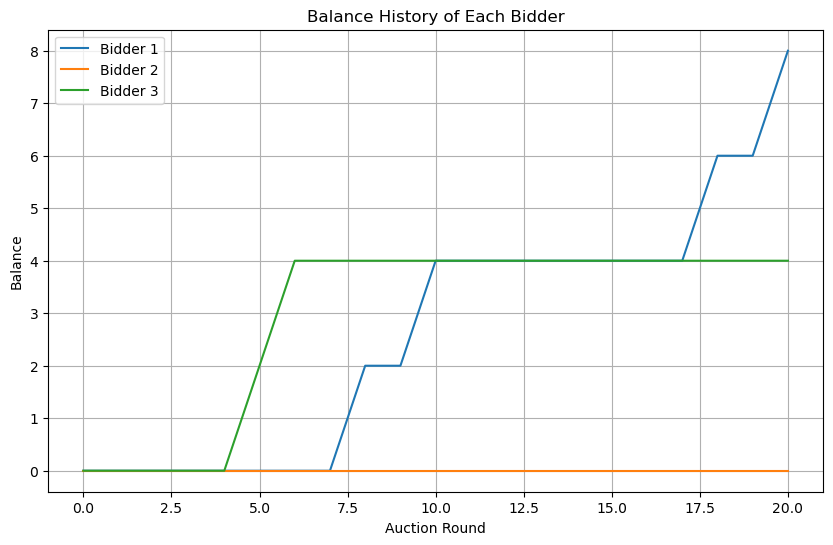

In [3]:
auction.plot_history() #calling plot history from the auction method.

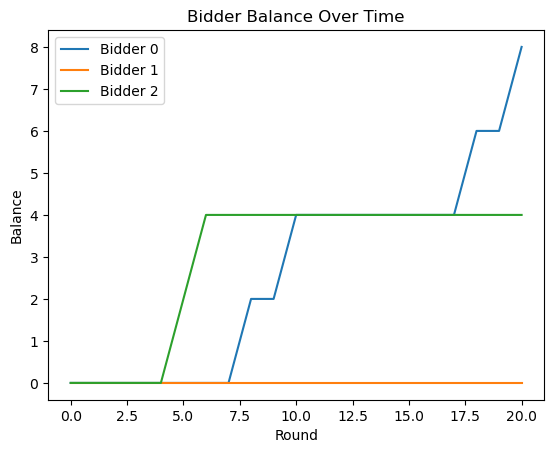

In [4]:
# Optional: Plotting the balance history for each bidder
for bidder, balance_history in auction.balances.items():
    plt.plot(balance_history, label=f'Bidder {bidders.index(bidder)}')

plt.xlabel('Round')
plt.ylabel('Balance')
plt.title('Bidder Balance Over Time')
plt.legend()
plt.show()

Testing to view if Balance less than -1000 is displayed as False

In [5]:
users = [User() for _ in range(2)]

# Create a single Bidder object with an initial balance close to -1000
bidders = [Bidder(num_users=len(users), num_rounds=5)]
bidders[0].balance = -1001  # Manually adjust the balance

# Create an Auction instance with the users and bidders
auction = Auction(users, bidders)

# Run the auction for a few rounds
for _ in range(5):
    auction.execute_round()

# Check the balance and qualification status of the bidder
for bidder in auction.bidders:
    print(f"Final Balance: {bidder.balance}, Is Qualified: {bidder.is_qualified}")

# Additionally, you can inspect the balance history
for bidder, history in auction.balances.items():
    print(f"Balance History: {history}")
    final_balance = balance_history[-1]
    print(f"Bidder {index}: Final Balance = {final_balance}")

Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Winner: Bidder 1 with bid: 0.1
Final Balance: -993, Is Qualified: True
Balance History: [-1001, -999, -997, -995, -995, -993]
Bidder 3: Final Balance = 4.0
